# Mutli-armed bandit problem

## Components (gambling, slot machines)
- (1) arms (option): each arm gives you a chance to win some money
- (2) reward (money): by pulling one arm, you could get some rewards
- (3) risky (gambling): you don't know ahead how much money you can get by pulling an arm


## Purpose
- (1) balance between exploration and exploitation 
- (2) maximize the reward or minimize the regret in your experiments

## Poperties
- (1) N arms corresponding to N options
- (2) by pulling one arm, you can get some money, which is unreliable (with some probability)
- (3) at the beginning, you have no idea about the rewards ahead 
- (4) we can only figure out the reward rates by experimenting (pulling arms)
- (5) every time, you are risking to get the highest amount of rewards


Therefore, we need to find some algorithm that can help us:
- (1) learn about new arms/options
- (2) earn as much money as possible

# Epsilon-Greedy Algorithm

## 1. Concepts

### 1.1 Greedy (exploitation)
- (1) the method always takes whatever best option known to it at the current time point (namely makes full use of existing knowledge, exploitation)
- (2) myopic: in the long run, the decision series made by the greedy algorithm might not get you highest benefits

### 1.2 Epsilon (exploration)
- controls to what extent you are going to explore in your experiments

### 1.3 Combination (epsilon-greedy)
- (1) balance between pure exploration and pure exploitation
- (2) whether to explore or exploit:
  - if you decide to explore, you need to make decisions on choosing one among the options (e.g. randomly draw)
  - If you decide to exploit, you need to make use of current information and picks the arm that gives the best performance

In [49]:
from platform import python_version

print(python_version())

# ! pip install pandas
! pip install matplotlib

3.8.5


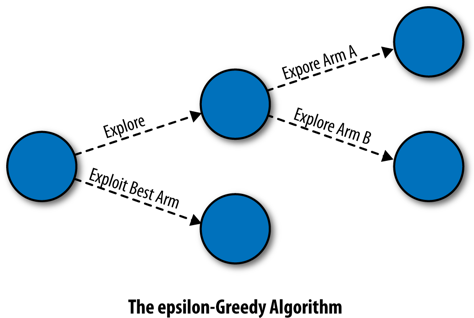

In [50]:
from IPython.display import Image
Image("epsilon_greedy_flow.png")

## 2. Implementation of a Bandit Problem in Python

### 2.1 Arm definition
* (1) Based on real-world problem
* (2) Bernoulli Arm
    * purchase rate
    * click-through rate
* (3) Gaussian Arm
    * number of visits
    * number of answers/comments
* (4) There could also be some other types



In [3]:
## define some arm class
class BernoulliArm():
    def __init__(self, p):
        self.p = p
        
    def draw(self):
        if random.random()>self.p:
            return 0.0
        else:
            return 1.0

In [4]:
## create more than one arms
import random
probabilities = [0.1, 0.2, 0.3, 0.5, 0.9, 0.1] ## arms can have the same distribution, i.e., two arms perform similarly
n_arms = len(probabilities)
arms = list(map(lambda mu: BernoulliArm(mu),probabilities))

for x in range(20):
    print(arms[3].draw())

0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0


### 2. Testing an Algorithm on the Bandit Problem

  
#### 2.1 Simulation test 
- get some rough sense on your data, and also the performance of the method. 
- do not expose the scripts to your real business before testing
- simulate arms and use these arms to the algorithm
- many rounds of simulations (average noises out)  

#### 2.2 Testing framwork
- (1) algorithm (epsilon-greedy algorithm)
- (2) multiple arms/options, which correspond to the real-world problem you are going to test
- (3) number of simulations: average noise over simulations
- (4) horizon: the number of time steps in each simulation

#### 2.3 Testing proceures
- (1) initialization: arms, algorithm, no prior knowledge on the arms
- (2) at each step, you need to: 
  - select some arm 
  - draw/pull the chosen arm, get the money
  - update with reward information 
- (3) performance analyses
  - which arm was chosen at each step
  - how well the algorithm performed at each step 


In [5]:
## implement test
def test_algorithm(algo, arms, num_sims, horizon):
    chosen_arms = [0 for i in range(num_sims*horizon)]
    rewards = [0 for i in range(num_sims*horizon)]
    cumulative_rewards = [0 for i in range(num_sims*horizon)]
    sim_rouns = [0 for i in range(num_sims*horizon)]
    time_steps = [0 for i in range(num_sims*horizon)]
    
    for sim in range(num_sims):
        sim = sim + 1
        algo.initialize(len(arms))
        
        for t in range(horizon):
            t = t + 1
            index = (sim-1)*horizon + t - 1
            sim_rouns[index] = sim
            time_steps[index] = t
            
            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm
            reward = arms[chosen_arm].draw()
            rewards[index] = reward
            
            if t == 1:
               cumulative_rewards[index] = reward
            else:
               cumulative_rewards[index] = cumulative_rewards[index-1] + reward 
            
            algo.update(chosen_arm, reward)
    return(sim_rouns, time_steps, chosen_arms, rewards, cumulative_rewards)

In [6]:
## simuate and test; this cell is not implementable -- just to show what needs to be done for a test
import os
import pandas as pd
import random
random.seed(4014) # to make sure that I can regenerate the results
output = ("simulate_eg.csv")


## initialization, arms
test_probabilities = [0.1,0.2,0.3,0.4,0.5]
n_arms = len(test_probabilities)
test_arms = list(map(lambda mu: BernoulliArm(mu),test_probabilities))

## initliazation testing arguments
N_SIMULATIONS = 1000
N_STEPS = 100

results =pd.DataFrame(test_algorithm(your_algo, test_arms, N_SIMULATIONS, N_STEPS)).transpose()
results.columns = ['n_sim', 'n_step', 'chosen_arm', 'rewards', 'cumulative_rewards']

NameError: name 'your_algo' is not defined

In [58]:
#this cell is not implementable -- just to show the saved results
# results.head() 

,n_sim,n_step,chosen_arm,rewards,cumulative_rewards,epsilon
0,1.0,1.0,0.0,0.0,0.0,0.1
1,1.0,2.0,0.0,0.0,0.0,0.1
2,1.0,3.0,0.0,0.0,0.0,0.1
3,1.0,4.0,0.0,0.0,0.0,0.1
4,1.0,5.0,0.0,1.0,1.0,0.1


## 3. Implementation of epsilon-greedy algorithm

### 3.1 Components (Initialization)
- (1) epsilon: controls to what extent you explore in the experiments
- (2) counts: track the number of pulls on each arm 
- (3) values/rewards: record the average reward on each arm

### 3.2 Actions 
- (1) select an arm: which arm to pull
- (2) update: get the reward, learn about the arm and update the values of the arm

In [7]:
class EpsilonGreedy():
    
    def __init__(self, epsilon, counts, values): 
        self.epsilon = epsilon
        self.counts = counts
        self.values = values
        return 
    
    def initialize(self, n_arms):
        self.counts = [0 for item in range(n_arms)]
        self.values = [0.0 for item in range(n_arms)]
        return
    
    def select_arm(self):
        if random.random()>self.epsilon:
            m = max(self.values)
            return self.values.index(m)
        else:
            return random.randrange(len(self.values))
        
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm]+1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n))*value + (1/float(n))*reward
        self.values[chosen_arm] = new_value
        return
        

In [8]:
## simuate and test
import os
import pandas as pd
import random
random.seed(4014) # to make sure that I can regenerate the results
output = ("simulate_eg.csv")


## initialization, arms
test_probabilities = [0.1,0.2,0.3,0.4,0.5]
n_arms = len(test_probabilities)
test_arms = list(map(lambda mu: BernoulliArm(mu),test_probabilities))

## initliazation testing arguments
N_SIMULATIONS = 1000
N_STEPS = 100

## loop to simulate, epsilon values is something I want to figure out before running real-world business
for epsilon in [0.1, 0.3, 0.8]:
    eg_algo = EpsilonGreedy(epsilon, [], [])
    eg_algo.initialize(len(test_arms))
    results =pd.DataFrame(test_algorithm(eg_algo, test_arms, N_SIMULATIONS, N_STEPS)).transpose()
    results.columns = ['n_sim', 'n_step', 'chosen_arm', 'rewards', 'cumulative_rewards']
    results['epsilon'] = epsilon
    if os.path.exists(output):
        results.to_csv(output, mode='a', header=None, index=False)
    else:
        results.to_csv(output, index=False)

In [9]:
import pandas as pd
all_results = pd.read_csv("simulate_eg.csv")


## 4. Performance Analyses

### 4.1 How probable the algorithm is choosing the best arm at each step
- (1) all algorithms converge after sufficient time steps
- (2) algorithms with higher epsilon values learn quickly -- reach at the stable level at an earlier time point
- (3) algorithms with lower epsilon values have higher probability of choosing the best arms at the stable level

### 4.2 How many rewards can you get at each step
- (1) quite similar to the plot on the best arm proportions
- (2) rewards of either 0 or 1 

### 4.3 How many cumulative rewards can you get at each step
- long-run value

### 4.4 Summary
- (1) after sufficient time, the epsilon-greedy algorithm can always converge
- (2) in addition to look at the short-term rewards, you must also check the long-run performance
- (3) the performance of the algorithms vary acorss different epsilon values. Sensitivity analyses might be needed.The decision on the epsilon value when you are leaving your experiments running in practice, should be based on (a) how different each option is; (b) how many rewards you can get on each option. 



In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

all_results['if_best_arm'] = np.where(all_results['chosen_arm']==test_probabilities.index(max(test_probabilities)), 1, 0)
results_plot = all_results.groupby(['epsilon', 'n_step'],as_index=False).aggregate({'if_best_arm': lambda x: x.sum()/float(x.count()), 'rewards':'mean', 'cumulative_rewards':'mean'})



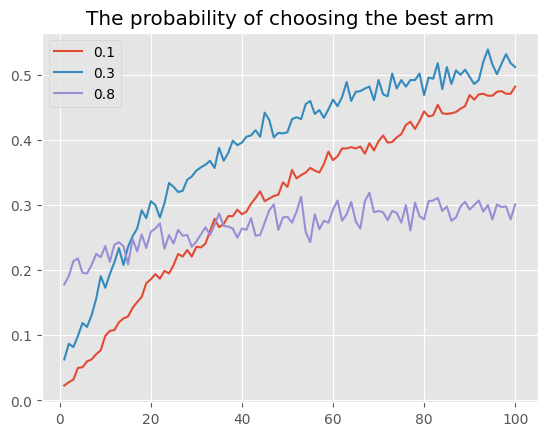

In [13]:
plt.style.use('ggplot')

# plot the probability of choosing the best arm
fig = plt.figure()
ax = fig.add_subplot(111)
for epsilon in results_plot['epsilon'].unique():
    results_epsilon = results_plot[results_plot['epsilon'] == epsilon]
    ax.plot(results_epsilon['n_step'],results_epsilon['if_best_arm'],label=str(epsilon))
plt.legend()
plt.title("The probability of choosing the best arm")
plt.savefig("best_arm.png")

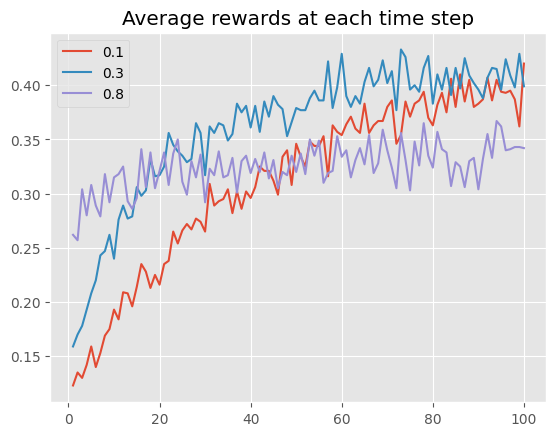

In [14]:
# plot the rewards at each time step
fig = plt.figure()
ax = fig.add_subplot(111)
for epsilon in results_plot['epsilon'].unique():
    results_epsilon = results_plot[results_plot['epsilon'] == epsilon]
    ax.plot(results_epsilon['n_step'],results_epsilon['rewards'],label=str(epsilon))
plt.legend()
plt.title("Average rewards at each time step")
plt.savefig("rewards.png")

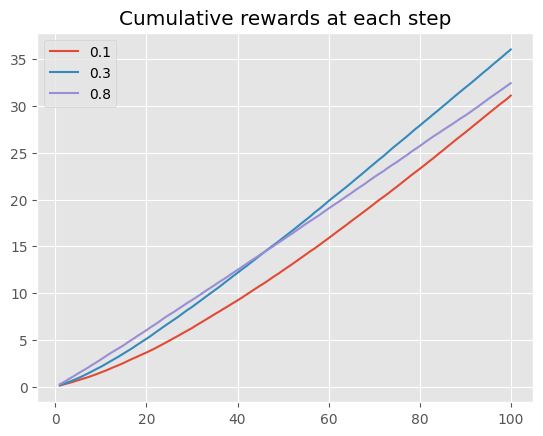

In [15]:
# plot the cumulative rewards at each time step
fig = plt.figure()
ax = fig.add_subplot(111)
for epsilon in results_plot['epsilon'].unique():
    results_epsilon = results_plot[results_plot['epsilon'] == epsilon]
    ax.plot(results_epsilon['n_step'],results_epsilon['cumulative_rewards'],label=str(epsilon))
plt.legend()
plt.title("Cumulative rewards at each step")
plt.savefig("cumulative_rewards.png")

## 5. Some Thoughts on Bandit Problem

- (1) active learning 
  - the method actively selects the data they should receive
- (2) online learning
  - the method analyzes data in real time and provides feedback immediately
- (3) feedback cycle
  - the behavior of the algorithm depends on the data it sees, but at the same time, the data depends on the algorithm's behavior

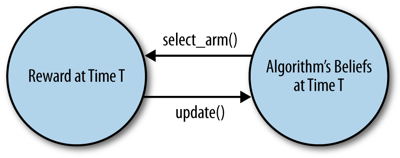

In [16]:
from IPython.display import Image
Image("feedback_cycle.png")